# Energy dependent neural model
Ismael Jaras (Universidad de Chile, Neurosistemas)

Taiki Harada (Tokyo Medical and Dental University)

In [1]:
pip install NeuroTools

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
from pathlib import Path
import os
import pickle
import numpy as np
import math
from NeuroTools.signals import AnalogSignal
from NeuroTools.signals.spikes import SpikeTrain
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import random
import seaborn as sns
%matplotlib inline

c:\users\taiki\appdata\local\programs\python\python37\lib\site-packages\NeuroTools\__init__.py:125: DependencyWarning: ** interval ** package is not installed.
To have functions using interval please install the package.
website : http://pypi.python.org/pypi/interval/1.0.0

  warnings.warn(get_import_warning(name), DependencyWarning)


## Backgrounds

The brain takes much cost of energy as the consumption occupies 20% of the whole human body's one . Neurons are requiring high energy demands and maitaining homehostatic ATP level. But if such a fundamental fucntion is corrupted, they get malfunctions leading to cell deaths which is strongly related to neurodegenerative diseases such as ALS, Parkinson disease and Alzheimer disease. So studying the effect of ATP on neural activities has a huge benefit on understanding machanisms underlying on such diseases. 

Almost all previous neural models have been ingnoring ATP kinetics inside or outside neurons while others were consdiering it in the level of single neurons but take too much running cost to simulate the network consisting of thousands of neurons (Le Masson, Neuro-glia energy feedback model). Actually there are a few models explaining ATP effect on neural network. But the problem is that they only think about Na/K ATPase's ATP consumtion while many articles about energy budget of neurons state about many neural activities such as housekeeping, Glutamate or GABA recycling and Ca activities, and didn't explain the relationship between ATP kinetics and membrane potential. According to Le Masson model, during the deficit of ATP, Na/K ATPase which is outruding sodium ions and intruding podium ions is inactivated and Ca buffering function is weakened causing high intracellular Ca level both of which make neurons more likely to fire leading to larger energy consumption and cell's death. Furthermore other articles about neurodegenerative disease or mitochondrial dysfunction mentioned that too much increment in intracellular Ca generated by such buffering paralyzation and high Ca intrusion on voltage-dependent Ca channels which is usually functioning as the modulator for timing and the efficacy of neurotransmitters on presynaptic terminals and on postsynapses caused by high activity of presynapses also malfunctions mitochondria which supplies ATP, and leads to serious energy deficit. For these reasons, ATP has a huge impact on neural activities. 

To observe the ATP impact on individual neurons and on neural network, as a first step, we described the ATP kinetics calculating each energy demand of each neural activities and combined its effect to membrane potential focusing on Na/K ATPase inactivation. To build up relatively simple neural model by which we can simulate a bunch of neurons, we constructed our model based on leaky integrate-and-fire model which is the simplest model and optimized the parameters using Particle Swarm Optimization method. Finally we could observe much better performances than leaky integrate-and-fire model and concluded our assumption about Na/K pump inactivation is a fundamental factor of spike generations. Also, during serious energy deficit, we could reproduce the high excitability of neurons and in a extreme case, the intracellular ATP level went down to 0 indicating the cell's death.

##Leaky integrate-and-fire model
$C_m\frac{dV_m}{dt}=-g_{leak}(V_m-E_{leak})+Input$

As you can see above, this model is the simplest one explaning only RC circuit.

If membrane potential $V_m$ reaches to the threshold $V_{th}$, a neuron fires ($V_m$-->$V_{ap}$). 

After the spike, the potential is reset to the reset potential $V_{reset}$.


In [4]:
class lif:
    def __init__(self,I_ext=[],dt=1,sim_time=0,V=-65,V_res=-70,EL=-70,c_m=281,g_leak=30,V_th=-50,V_ap=40,t_ref=2.5):
        # injected current
        self.I_ext=I_ext

        # hyper parameters
        self.sim_time=sim_time
        
        # major variables
        self.V=V  # mV
        self.V_res=V_res
        self.EL=EL
        self.V_th=V_th  # mV
        self.V_ap=V_ap  # mV
        
        self.t_ref=t_ref  # s
        
        # about time
        self.sim_time=sim_time
        self.dt=dt
        self.resttime=0
        
        # logs
        self.V_log=[]
        self.Input_log=[]
        self.fire_count=[] # the time of spikes
        
        # C & g of soma
        self.C_m=c_m 
        self.g_leak=g_leak
        self.tau_m=c_m/g_leak

    def grad_V(self,V,Input):
        #return (-self.g_leak/self.C_m*(V-self.V_res)+Input/self.C_m)
        return (-(V-self.EL) + Input/self.g_leak)/(self.tau_m)*1000 
    
    def train(self,t):
        return self.I_ext[int(t/self.dt)]

    def Input_func(self,t):
        self.Input_log.append(self.train(t))
    
    def simulate_onestep(self,t,dt):
        self.V_log.append(self.V)
        self.dt=dt
        self.Input_func(t)
        
        # during refractory time
        if self.resttime>0:
            self.resttime-=1
                    
        
        else:
            # subthreshold
            if self.V<self.V_ap:
                x=self.V+self.grad_V(self.V,self.Input_log[-1])*dt*0.001
                
                # fire
                if x>=self.V_th:
                    # describe each release site's activity
                    self.V=self.V_ap
                    self.fire_count.append(t/1000)
                    
                    
                # subthreshold dynamics    
                else:
                    self.V=x
                    
            # reset         
            else:
                self.V=self.V_res
                self.resttime=self.t_ref/dt
        
                

##Energy-dependent leaky integrate-and-fire model
Our single neural model is based on Leaky-Integrate-Fire model. If membrane potential ($V_m$) of j-th neuron's soma is under the threshold potential ($V_{th}$), the dynamics of membrane potential can be described by the following differential equation:
\begin{equation}
    C_m\cdot \frac{dV_m}{dt}=-g_{leak}\cdot (V_m-E_{leak})+Input
\end{equation}
with $C_m$ representing the membrane capacitance $[pF]$, $g_{leak}$ representing the membrane conductance $[nS]$ and $E_{leak}$ the reversal potential of membrane $[mV]$. $Input$ denotes the amount of injected current.

If $V_m$ exceeds the $V_{th}$, a neuron spikes and $V_m$ reaches to the peak potential ($V_{ap}$). After a spike, $V_m$ is reset immediately to the reset potential ($V_{reset}$). In our model, motivated by Leaky integrate and fire model with partial reset we take this value as a variable dependent on neural state and this value is calculated by this equation:
\begin{equation}
    V_{reset}=\beta\cdot V_{th}  
\end{equation}
where $1 \leq \beta \leq \frac{V_{res}}{V_{th}}$ and $V_{res}$ is the resting potential. In our model, we assume that the lack of intracellular ATP makes a neuron more likely to fire inactivating $Na^+/K^+ ATPase$s which extrude 3 sodium ions and intrude 2 podium ions per 1 ATP molecule shown previously by "A Computational Model of Motor Neuron Degeneration". And we define $\beta$ as a function whose variable is the concentration level of intracellular ATP ($[ATP](t)$) by this equation:
\begin{equation}
\alpha=\frac{V_{reset}}{V_{th}}-1
\end{equation}

\begin{equation}
\beta(ATP)=alpha\cdot(2-(\frac{2}{1+e^{-\frac{ATP_h-ATP}{ATP_h}\cdot sensitivity}}))
\end{equation}
In neural activities, a neuron consumes ATP and also maintain the energy balance. According to previous articles, such energy demands contain \textit{signaling} process ($E_{signaling}$)and \textit{non-signaling} one ($E_{nonsignaling}$). Each process is also divided into more specific one. \textit{signaling} process includes energy demands for action potential ($E_{AP}$), synaptic transmission ($E_{ST}$), glutamate or GABA recycling ($E_{glu}$,$E_{GABA}$) and calcium activity ($E_{Ca}$). \textit{non-signaling} process includes energy demands for house-keeping ($E_{HK}$) and resting potential maintenance ($E_{RP}$). We assume that $E_{HK}$ is always consumed and $E_{RP}$ is consumed except when a neuron fires. The amount of these \textit{non-signaling} is supposed to be constant, and thus we don't consider time-delay of consuming such types of energy demands. On the other hand, we should consider time-delay when it comes to \textit{signaling} process which is triggered by each action potential, because many biochemical reactions in synaptic transmission, such as synaptic vesicle cycling and the binding of neuromodulators to receptors are not instantaneously completed, the metabolic energy does not suddenly decrease due to the transmission of action potentials. Here, to describe this time-delay, we use an exponential function like a previous article\cite{energy_constraints_china} as below:
\begin{equation}
    rate(t)=\frac{(t-t_0)}{\tau^2}\cdot e^{-\frac{(t-t_0)}{\tau}}
\end{equation}
where in case of $E_{AP}$, $t_0$ means the time when the spike is generated at the axonal initital segment while in case of others which are related to synaptic transmission, it means the time when an action potential is transmitted in the form of synaptic tranmitters to postsynapses. Note that regardless of the value of $\tau$, the total of this function ($t_0\leqq t\leqq \infty$) is equal to 1. So all we have to do to calculate the energy demand at each time is multiply each total amount of it to this rate. In addition, the total amount of each \textit{signaling} energy demand is already estimated by previous articles. Each energy demand can takes different values dependent on excitatory synapses or inhibitory ones. 
After calculating the amount of energy consumption at each time ($ATP_{use}(t)$) [mol/s], a neuron uses the amount and mitochondrias supply ATP to maintain energy balance simultaneously. We define the amount of ATP supply [mol/L$\cdot$s] at time $t$ following below:
\begin{equation}
    [ATP]_{supply}(t)=K\cdot ([ATP]_h-[ATP](t))
\end{equation}
where $K$ means the "recovery rate" ([/ms]) and $[ATP]_h$ means the homeostatic level of the concentration level of intracellular ATP. So the differential equtation of $[ATP](t)$ can be described as below:
\begin{equation}
    \frac{d[ATP](t)}{dt}=[ATP]_{supply}(t)-\frac{ATP_{use}(t)}{Vol} 
\end{equation}
$Vol$ is the volume of a neuron. 

This ATP dynamics as we mentioned above is strongly related to the morphological features, and thus each energy demand should vary with them. But as a first step, we fixed the morphological features shown on the "Evaluating the gray and white matter energy budgets of human brain function" article.

##$\beta(ATP)$
\begin{equation}
\alpha=\frac{V_{reset}}{V_{th}}-1
\end{equation}
\begin{equation}
\beta(ATP)=1+\alpha\cdot(2-(\frac{2}{1+e^{-\frac{ATP_h-ATP}{ATP_h}\cdot sensitivity}}))
\end{equation}
$ATP_h$ and $sensitivity$ denote the homehostatic level of ATP and the degree of change of reset potential respectively.

Note that if $sensitivity$ increases, the sharpness of this sigmoid-like curve becomes strong, furthermore huge $sensitivity$ makes this step-like function.

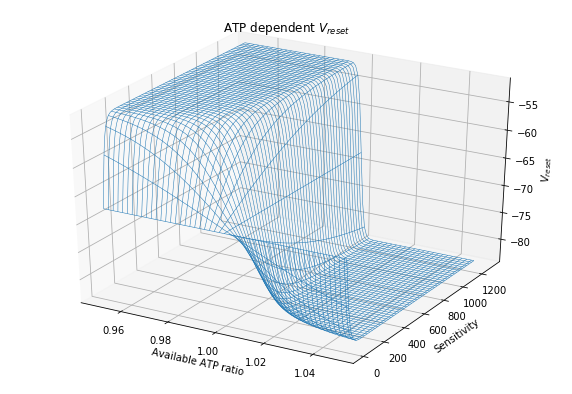

In [5]:
V_th=-51.5
V_res=-67.5435
scale_alpha=V_res/V_th-1
ATP_h=1e-4

def beta(ATP,sensitivity):
  return 1+scale_alpha*(2-(2/(1+np.exp(-(ATP_h-ATP)/ATP_h*sensitivity))))

aa=np.arange(9.5e-5,1.05e-4,1e-7)
ss=np.arange(0,1300,1)
xv,yv=np.meshgrid(aa,ss)
bb=beta(xv,yv)*V_th
fig1=plt.figure(figsize=(10,7))
ax1=plt.axes(projection='3d')
ax1.set_title('ATP dependent $V_{reset}$')
ax1.set_xlabel('Available ATP ratio')
ax1.set_ylabel('Sensitivity')
ax1.set_zlabel('$V_{reset}$')
ax1.plot_wireframe(xv/ATP_h,yv,bb,linewidth=0.5)
plt.show()

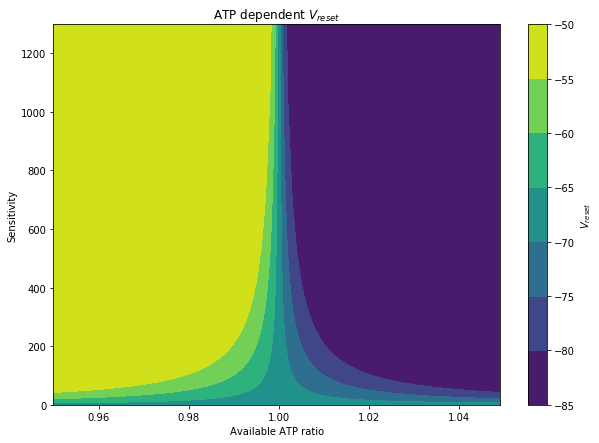

In [6]:
fig2=plt.figure(figsize=(10,7))
ax2=fig2.add_subplot(111)
ax2.set_title('ATP dependent $V_{reset}$')
ax2.set_xlabel('Available ATP ratio')
ax2.set_ylabel('Sensitivity')
co=ax2.contourf(xv/ATP_h,yv,beta(xv,yv)*V_th)
bar=fig2.colorbar(co)
bar.set_label('$V_{reset}$')
plt.show()

In [7]:
class edlif:
    def __init__(self,I_ext=[],neuron_type='E',dt=1,sim_time=0,delay_func="poisson",
                 K=1,ATP=10**(-4),ATP_h=10**(-4),half_step=False,sensitivity=10,
                 V=-65,V_res=-70,EL=-70,c_m=281,g_leak=30,V_th=-50,V_ap=40,t_ref=2.5,tau_ap=50):
        
        # injected current
        self.I_ext=I_ext

        # Excitatory or inhibitory
        self.neuron_type=neuron_type
        
        # hyper parameters
        self.half_step=half_step
        self.sim_time=sim_time
        self.delay_func=delay_func
        self.sensitivity=sensitivity
        self.ATP_h=ATP_h # mol/L
        self.K=K
        
        # major variables
        self.ATP=ATP # mol/L
        self.V=V  # mV
        self.V_res=V_res
        self.EL=EL
        self.V_th=V_th  # mV
        self.V_ap=V_ap  # mV
        self.scale_alpha=V_res/V_th-1
        self.t_ref=t_ref  # s
        
        # about time
        self.sim_time=sim_time
        self.dt=dt
        self.resttime=0
        
        # logs
        self.t_log=[] 
        self.V_log=[]
        self.Input_log=[]
        self.ATP_use=[]
        self.ATP_produce=[]
        self.ATP_log=[]
        self.fire_count=[] # the time of spikes
        
        # Values of morphological features and the amount of energy use of each activity
        self.avogadro=6.02214086*10**23
        self.elementarycharge=1.60217662*10**(-19) # C
        self.Faradey=self.avogadro*self.elementarycharge # seg*A/mol = Coulomb/mol
        
        self.L_axon=4 # cm  
        self.L_dendrite=0.44 # cm 
        self.D_axon=0.512*10**(-4) # 0.3*10**(-1) # cm
        self.D_dendrite=0.9*10**(-4) # cm
        self.D_soma=25*10**(-4) # cm
        self.Volume_soma=4/3*np.pi*(self.D_soma/2)**3*10**(12)#12660 # um**3
        self.Volume_axon=np.pi*(self.D_axon/2)**2*self.L_axon*10**(12) #1000 # um**3
        self.Volume_dendrite=np.pi*(self.D_dendrite/2)**2*self.L_dendrite*10**(12) #4349 # um**3
        self.Volume_total=(self.Volume_soma+self.Volume_axon+self.Volume_dendrite)*10**(-15) # dm**3 = L
        
        # The amount of each energy demand (ref:Evaluating the gray and white matter energy budgets of human brain function)
        if self.neuron_type=='E':
            self.E_housekeeping=5.38*10**5/self.avogadro # mol/ms
            self.E_restingpotential=6.82*10**5/self.avogadro # mol/ms
            self.E_ap= 2.65*10**8/self.avogadro  # Assuming 1 Hz mol
            self.E_ligand= 1.41*10**8/(8000*.25)/self.avogadro # start consuming when a vesicle is released (here we assume a vesicle is released and at the same time ligands are relased from it)
            self.E_Ca= 1.16*10**8/(8000*.25)/self.avogadro # start consuming when a vesicle is released
        
        if self.neuron_type=='I':
            self.E_housekeeping=3.55*10**5/self.avogadro # mol/ms
            self.E_restingpotential=3.41*10**5/self.avogadro # mol/ms
            self.E_ap= 3.09*10**8/self.avogadro/2  # Assuming 2 Hz, so divided by 2
            self.E_ligand= 1.82*10**8/(8000*.25)/self.avogadro/2 # start consuming when a vesicle is released (here we assume a vesicle is released and at the same time ligands are relased from it)
            self.E_Ca= 2.31*10**8/(8000*.25)/self.avogadro/2 # consumed when a vesicle is released
        
        self.E_st_E= 15.8*10**8/(8000*.25)/self.avogadro# ref:Evaluating the gray and white matter energy budgets of human brain function
        self.E_st_I= 20.5*10**8/(8000*.25)/self.avogadro/2# (divided by 2) ref:Evaluating the gray and white matter energy budgets of human brain function
        
        # C & g of soma
        self.C_m=c_m 
        self.g_leak=g_leak
        self.tau_m=c_m/g_leak

        # basal ATP production
        self.ATP_basal=(self.E_housekeeping + self.E_restingpotential) # mol/ms
        
        # tau 
        self.tau_ap=tau_ap # ms
        
        
    def E_ap_time_delay(self,t):
        if len(self.fire_count)>0:
            f_array=np.array(self.fire_count)
            return sum(self.delay(t,f_array,self.tau_ap))*self.E_ap
        else:
            return 0
        
    
    def delay(self,t,ti,tau):
        if tau==0:
            if t==ti[-1]+1:
                a=list(np.zeros(len(ti)-1))
                return np.array(a+[1])
            else:
                return np.zeros(len(ti))
        
        # various kernel functions
        else:
            if self.delay_func=="poisson":
                return (t-ti)/(tau**2)*np.exp(-(t-ti)/tau) 
            
    def grad_V(self,V,Input):
        #return (-self.g_leak/self.C_m*(V-self.V_res)+Input/self.C_m) # considering [ms] and [mV]
        return (-(V-self.EL) + Input/self.g_leak)/(self.tau_m)*1000   
        
    def beta(self,ATP):
        return 1+self.scale_alpha*(2-(2/(1+np.exp(-(self.ATP_h-ATP)/self.ATP_h*self.sensitivity))))
    
    def train(self,t):
        return self.I_ext[int(t/self.dt)]

    def Input_func(self,t):
        self.Input_log.append(self.train(t))
    
    def simulate_onestep(self,t,dt):
        self.ATP_log.append(self.ATP)  # mol/L
        self.V_log.append(self.V)
        self.t_log.append(t)
    
        self.dt=dt
        self.Input_func(t)
        
        # calculate E_ap(t)
        E_ap_delay=self.E_ap_time_delay(t)
        
        if self.ATP==0:
          self.V=self.V_th
          self.ATP_use.append(0)
           

        # during refractory time
        elif self.resttime>0:
            self.resttime-=1
            self.ATP_use.append(self.E_restingpotential+self.E_housekeeping+E_ap_delay) 
                    
        
        else:
            # subthreshold
            if self.V<=self.V_th:
                x=self.V+self.grad_V(self.V,self.Input_log[-1])*dt*0.001
                
                # fire
                if x>=self.V_th:
                    # describe each release site's activity
                    self.V=self.V_ap
                    self.ATP_use.append(E_ap_delay+self.E_housekeeping)
                    self.fire_count.append(t/1000)
                    
                # subthreshold dynamics    
                else:
                    self.V=x
                    self.ATP_use.append(self.E_restingpotential+E_ap_delay+self.E_housekeeping)
                    
            
            # reset         
            else:
                self.V=self.beta(self.ATP)*self.V_th
                self.resttime=self.t_ref/dt
                self.ATP_use.append(self.E_restingpotential +E_ap_delay+self.E_housekeeping)
                
        # ATP use and supply
        ATP_consume=self.ATP_use[-1]/self.Volume_total # mol/(L s)    
        
        if self.half_step==True:
            # consume ATP
            self.ATP-=ATP_consume*dt
            # produce ATP
            if self.ATP<=self.ATP_h:
                ATP_produce=self.K*(self.ATP_h-self.ATP)  # mol/L 
                production_max=300*self.ATP_basal/self.Volume_total
                if ATP_produce<=production_max:
                    ATP_produce=ATP_produce
                else:
                    ATP_produce=production_max  
            else:
              ATP_produce=0
              
            self.ATP+=ATP_produce*dt
                
        else:    
            # produce ATP
            if self.ATP<=self.ATP_h:
                if self.ATP==0:
                  ATP_produce=0
                else:
                  ATP_produce=self.K*(self.ATP_h-self.ATP)  # mol/(L ms)
                production_max=300*self.ATP_basal/self.Volume_total
                if ATP_produce<=production_max:
                  ATP_produce=ATP_produce
                else:
                    ATP_produce=production_max
            else:
              ATP_produce=0
              
            self.ATP+=(ATP_produce - ATP_consume)*dt
        if self.ATP<0:
          self.ATP=0
        self.ATP_produce.append(ATP_produce*self.Volume_total)  # mol/ms  

##Optimization
We used data from "Quantitative Single Neuron Modeling Competition
2009". Since test data isn's avalilable in the github (https://github.com/INCF/QSNMC), we only used training data. 

1. "The quantitative single-neuron modeling competition."
Biol Cybern. 2008 Nov; 99(4-5):417-26.
Jolivet R, Schürmann F, Berger TK, Naud R, Gerstner W, Roth A.

2. "Quantitative Single-Neuron Modeling: Competition 2009"
Neuroinformatics 2009.  
Naud R, Berger T, Bathellier B, Carandini M, Gerstner W.  


###The data used for optimization

In [9]:
print((0.4167284328912628+0.4148956248441885+0.41920752053159127+0.433322740307315+0.3604088170082034+0.3906681190592216)/6)

0.4058718757736304


In [10]:
print((0.3860243289079641+0.40091934273468033+0.41729173019650745+0.4131819172590979+0.3453728591728895+0.39697803869194426)/6)

0.39329470282718054


####The structure of training data
The training data consists of injected current and voltage. The [Hz] of recording is 10000 which means time step is 0.1 [ms]. Total duration of stimulation is 60.0001 [s]. Voltage data is including 13 trials of the same stimulation with the 39 [s] of duration and we obtained spike timing from these trials using AnalogSignal class of NeuroTools module. The noise starts at around 15 [s]. 

We divided 13 spike trains data into 10 for training and 3 for test and suffled the order 5 times which means we carried out k-fold cross validation.

In [11]:
# load and organize training data from QSNMC
full_path = '.'

def load_training_data(pickled=True):
    if pickled:
        current_pickle_path = '%s/current.pickle' % full_path
        voltage_pickle_path = '%s/voltage_allrep.pickle' % full_path
        if not (os.path.isfile(current_pickle_path) \
                and os.path.isfile(voltage_pickle_path)):
            print("Pickled data not found; pickling from raw data files...")
            pickle_training_data()
        print("Loading training data from pickled files...")
        with open(current_pickle_path,'rb') as f:
            current = pickle.load(f,encoding="latin1")
        with open(voltage_pickle_path,'rb') as f:
            voltage = pickle.load(f,encoding="latin1")
    else:
        print("Loading training data from raw data files...")
        current = np.loadtxt('%s/current.txt' % full_path)
        voltage = np.loadtxt('%s/voltage_allrep.txt' % full_path)
    return (current,voltage)
dt = 1e-4
def get_observation(phase):
    if phase == 'training':
        load_data = load_training_data
    elif phase == 'testing':
        load_data = load_testing_data
    else:
        raise Exception("Phase must be 'training' or 'testing'")
    
    current_array,voltage_array = load_data() 
    spike_trains = []
    
    for col in range(voltage_array.shape[1]):
        voltage_trial = voltage_array[:,col]
        vm_trial = AnalogSignal(voltage_trial,dt)  
        spike_train = vm_trial.threshold_detection(0)
        spike_trains.append(spike_train)
    
    current = AnalogSignal(current_array,dt)
    observation = {'current':current,'spike_trains':spike_trains}

    return observation

In [12]:
# injected current: 60.0001 s
train_data=get_observation('training')
current=train_data["current"]
i_ext=current.signal
dt=current.dt
steps=len(i_ext)
print("Simulation step [s] : ",dt)
print("Total steps : ",steps)

Loading training data from pickled files...
Simulation step [s] :  0.0001
Total steps :  600001


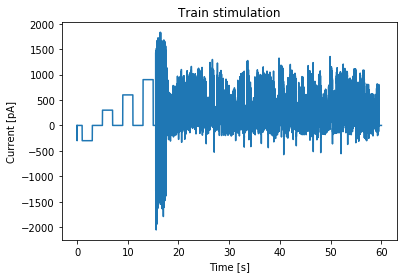

In [13]:
plt.title("Train stimulation")
plt.xlabel("Time [s]")
plt.ylabel("Current [pA]")
plt.plot(np.arange(0,60.0001,dt),i_ext)
plt.show()

In [14]:
# Tmax: 39 s
spike_train=train_data["spike_trains"]
T_max=0
for train in spike_train:
  T_max=max(T_max,train.duration())
  
T_total=T_max
print("Duration of Spike train [s] : ",T_total)

Duration of Spike train [s] :  39.0


Loading training data from pickled files...


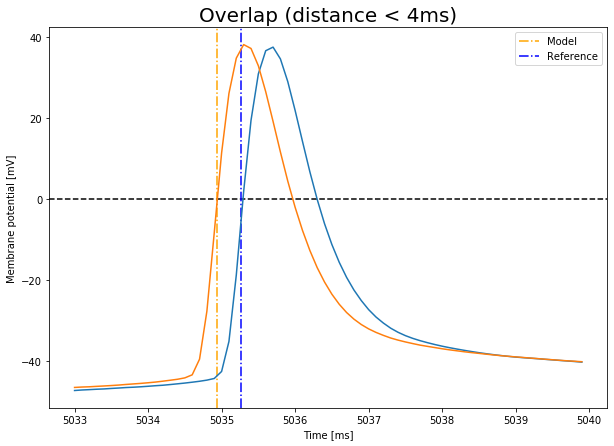

In [15]:
i=3
j=4
current_array,voltage_array = load_training_data()
vol=voltage_array[:,i]
vol1=voltage_array[:,j]
start=50330
end=50400
tt=np.arange(start,end,1)
plt.figure(figsize=(10,7))
plt.title('Overlap (distance < 4ms)',fontsize=20)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane potential [mV]')
plt.axhline(ls='--',color='black')
plt.axvline(5034.94,ls='-.',color='orange',label='Model')
plt.axvline(5035.27,ls='-.',color='b',label="Reference")
plt.legend(loc='upper right')
plt.plot(tt/10,vol[start:end])   
plt.plot(tt/10,vol1[start:end])

Loading training data from pickled files...


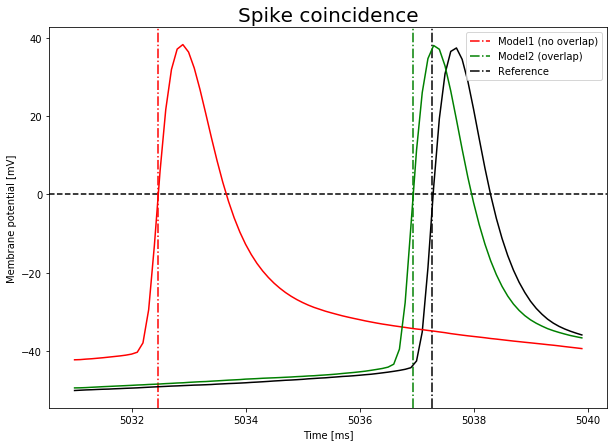

In [16]:
i=3
j=4
current_array,voltage_array = load_training_data()
vol=voltage_array[:,i]
vol1=voltage_array[:,j]
tt=np.arange(50310,50400,1)
plt.figure(figsize=(10,7))
plt.title('Spike coincidence',fontsize=20)
plt.xlabel('Time [ms]')
plt.ylabel('Membrane potential [mV]')
plt.axhline(ls='--',color='black')
plt.axvline(5032.46,ls='-.',color='r',label='Model1 (no overlap)')
plt.axvline(5036.94,ls='-.',color='g',label='Model2 (overlap)')
plt.axvline(5037.27,ls='-.',color='black',label="Reference")
plt.legend(loc='upper right')
plt.plot(tt/10,vol[50290:50380],color='black')   
plt.plot(tt/10,vol1[52040:52130],color='r')
plt.plot(tt/10,vol1[50290:50380],color='g')


#### Time step for simulation of models
The time step for our optimization and simulation is set to 1 [ms]. For this reason, we reshaped the current data. The simulation duration is the same as the one of voltage data, 39 [s].

In [17]:
# extract current of each 1 ms
I_ext=list(i_ext)[::int(1/(dt*1000))]


100%|█████| 39000/39000 [00:00<00:00, 62667.15it/s]

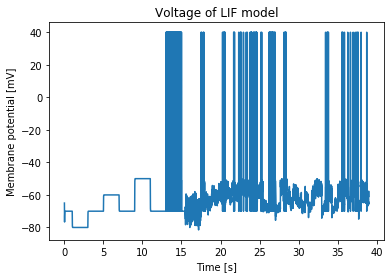

In [18]:
# Check LIF model
LIF=lif(I_ext=I_ext,dt=1,sim_time=T_max*1000,V=-65,V_res=-70,EL=-70,c_m=281,
        g_leak=30,V_th=-50,V_ap=40,t_ref=2.5)
tt=np.arange(0,T_max*1000,1)
pbar=tqdm(total=len(tt))
for t in tt:
  LIF.simulate_onestep(t,1)
  pbar.update(1)
pbar.close()
plt.title('Voltage of LIF model')
plt.xlabel('Time [s]')
plt.ylabel('Membrane potential [mV]')
plt.plot(tt/1000,LIF.V_log)


100%|██████| 39000/39000 [00:08<00:00, 4627.72it/s]

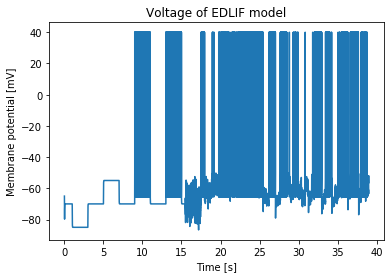

In [19]:
# Check EDLIF model
EDLIF=edlif(I_ext=I_ext,neuron_type='E',dt=1,sim_time=T_max*1000,delay_func="poisson",
            K=1,ATP=10**(-4),ATP_h=10**(-4),half_step=False,sensitivity=1000,V=-65,
            V_res=-70,EL=-70,c_m=200,g_leak=20,V_th=-50,V_ap=40,t_ref=10,tau_ap=50)
tt=np.arange(0,T_max*1000,1)
pbar=tqdm(total=len(tt))
for t in tt:
  EDLIF.simulate_onestep(t,1)
  pbar.update(1)
pbar.close()
plt.title('Voltage of EDLIF model')
plt.xlabel('Time [s]')
plt.ylabel('Membrane potential [mV]')
plt.plot(tt/1000,EDLIF.V_log)

###Particle Swarm Optimization
This model for optimization is based on the stragetic movement of a swarm of beas, fishes, birds or so on. 

According to Wikipedia, the explaination is like this;

In computational science, particle swarm optimization (PSO) is a computational method that optimizes a problem by iteratively trying to improve a candidate solution with regard to a given measure of quality. It solves a problem by having a population of candidate solutions, here dubbed particles, and moving these particles around in the search-space according to simple mathematical formulae over the particle's position and velocity. Each particle's movement is influenced by its local best known position, but is also guided toward the best known positions in the search-space, which are updated as better positions are found by other particles. This is expected to move the swarm toward the best solutions.

PSO is originally attributed to Kennedy, Eberhart and Shi and was first intended for simulating social behaviour, as a stylized representation of the movement of organisms in a bird flock or fish school. The algorithm was simplified and it was observed to be performing optimization. The book by Kennedy and Eberhart describes many philosophical aspects of PSO and swarm intelligence. An extensive survey of PSO applications is made by Poli. Recently, a comprehensive review on theoretical and experimental works on PSO has been published by Bonyadi and Michalewicz.

PSO is a metaheuristic as it makes few or no assumptions about the problem being optimized and can search very large spaces of candidate solutions. However, metaheuristics such as PSO do not guarantee an optimal solution is ever found. Also, PSO does not use the gradient of the problem being optimized, which means PSO does not require that the optimization problem be differentiable as is required by classic optimization methods such as gradient descent and quasi-newton methods.
(https://en.wikipedia.org/wiki/Particle_swarm_optimization)

####Initial positions & Time-changing $w$
We set normal distribution whose bounds are equal to the ones given to the space where each individual is exploring. 

The weight of inertia vector $w$ is set to the inverse exponential function so that at the first individuals can explore the space enough and at the end they can converge to the best position appropriately.

In [20]:
class Particle:
  def __init__(self,x,index,c1,c2,precision):
    self.dim=len(x)
    self.pos_i=x
    self.vel_i=np.random.uniform(-1,1,self.dim)
    self.pos_best_i=[]
    self.err_best_i=1
    self.err_i=1
    self.c1=c1
    self.c2=c2
    self.index=index
    self.precision=precision
  
  def evaluate(self,costFunc):
    self.err_i=costFunc(self.pos_i,self.index,self.precision)

    # update pos_best_i and err_best_i
    if self.err_i < self.err_best_i:
      self.pos_best_i=self.pos_i
      self.err_best_i=self.err_i

  def update_vel(self,pos_best_g,w):
    r1=np.random.random(self.dim)
    r2=np.random.random(self.dim)
    vel_cognitive=self.c1*r1*(np.array(self.pos_best_i)-np.array(self.pos_i))
    vel_social=self.c2*r2*(np.array(pos_best_g)-np.array(self.pos_i))
    self.vel_i=w*self.vel_i+vel_cognitive+vel_social

  def update_pos(self,bounds):
    self.pos_i+=self.vel_i

    for i in range(self.dim):
      if self.pos_i[i] > bounds[i][1]:
        self.pos_i[i] = bounds[i][1]
      if self.pos_i[i] < bounds[i][0]:
        self.pos_i[i] = bounds[i][0]

class PSO():
  def __init__(self,costFunc,bounds,N,iter,index,c1,c2,precision):
    self.err_log=np.zeros((N,iter))
    xdim=len(bounds)
    
    self.pos_best_g=[]
    
    err_best_g=1
    
    swarm=[]
    for i in range(N):
      xx=[]
      for d in range(xdim):
        xx.append(np.random.uniform(bounds[d][0],bounds[d][1]))
      swarm.append(Particle(xx,index,c1,c2,precision))
      
    print("Birds are exploring....")
    i=0
    
    pbar=tqdm(total=iter*N)    
    while i < iter:
      w=np.exp(-i/iter)
        
      for j in range(N):
        swarm[j].evaluate(costFunc)
        self.err_log[j,i]=swarm[j].err_i
        
        if swarm[j].err_i < err_best_g:
          self.pos_best_g = copy.deepcopy(swarm[j].pos_i)
          err_best_g = swarm[j].err_i
        pbar.update(1)
      print("Best position so far : ",self.pos_best_g)
      print("Best error so far : ",err_best_g)  
      if xdim==3:
        plt.ion()
        fig=plt.figure()
        ax=fig.add_subplot(111,projection='3d')
        ax.set_xlabel('C_m')
        ax.set_ylabel('g_leak')
        ax.set_zlabel('t_ref')
        ax.set_xlim(bounds[0])
        ax.set_ylim(bounds[1])
        ax.set_zlim(bounds[2])
        positions=np.zeros((xdim,N))
        for n in range(N):
          for d in range(xdim):
            positions[d,n]=swarm[n].pos_i[d]
        X=list(positions[0,:])
        Y=list(positions[1,:])
        Z=list(positions[2,:])
        ax.scatter(X,Y,Z,cmap='viridis',marker='o')
        ax.scatter(self.pos_best_g[0],self.pos_best_g[1],self.pos_best_g[2],color='r',marker='^')
        plt.draw()
        plt.show()
        
      for j in range(N):
        swarm[j].update_vel(self.pos_best_g,w)
        swarm[j].update_pos(bounds)
        
      
      i+=1
    pbar.close()  
        
    print("Iteration :",iter)
    print("Optimized parameters :",self.pos_best_g)
    print("Minimum error :",err_best_g)
    plt.title("Error value of each particle")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    for i in range(N):
      plt.plot(range(iter),self.err_log[i,:])
    plt.show()


####Cost Fucntion
Ref: "A benchmark test for a quantitative assessment
of simple neuron models"

In order to measure the similarity or dissimilarity between
two spike trains and assess the quality of the predictions of
models, we need a measure to compare spike trains as
predicted by the model to spike trains as generated by the original cell. 

In precedent reports, some of us have consistently used the coincidence factor $\Gamma$ as defined in Refs. (Clopath et al., 2007; Jolivet and Gerstner, 2004; Jolivet et al., 2004, 2006; Kistler et al., 1997).

The coincidence factor can be computed quickly and easily. It is written;
\begin{equation}
\Gamma_k=\frac{N_{coinc}-<N_{coinc}>}{1/2(N_{ref}^k+N_{model})}\frac{1}{N}
\end{equation}
where $N_{data}^k$ is the number of spike in the $k$th traial of reference spike trains, $N_{model}$ is that in the predicted spike train obtained from models. $N_{coinc}$ is the number of coincidences with precision $\Delta$ between two spike trains, and $<N_{coinc}>=2f\Delta N_{ref}^k$ is the expected number of coincidences generated by a homogenous Poisson process with the same rate $f$ as the spike train of models. The factor $N=[1-2f\Delta]$ normalizes $\Gamma$ to a maximum value of one which is reched only if two spike trains are the same with precision $\Delta$.

For training, as written above, we used 10 trials and averaged this score dividing it by the number of data (10). According to the reference, it's called 'Raw $\Gamma$' 

In [21]:
def N_coinc(spike_model,spike_ref,precision):
  n_coinc=0
  for sr in spike_ref:
    coinc_ref=0
    for sm in spike_model:
      if coinc_ref==1:
        coinc_ref=1
      elif sm <= sr+precision and sm >= sr-precision:
        coinc_ref+=1
    n_coinc+=coinc_ref
      
  return n_coinc

def gamma(spike_model,spike_ref,precision):
  N_ref=len(spike_ref)
  N_model=len(spike_model)
  r=N_model/T_max
  N_coinc_expected=2*r*N_ref*precision
  N_norm=1-2*r*precision
  return 1/N_norm*(N_coinc(spike_model,spike_ref,precision)-N_coinc_expected)/(0.5*(N_ref+N_model))

#####$\Delta$ & $\Gamma$
If we compare two spike trains obtained from reliable model and from reference, $\Delta$ doesn't affect the score so much with some range, but in case of models which perform badly, it does. By convention, $\Delta=2 [ms]$ is thought to be appropriate and we chose the value.

In [22]:
precision=0.004

In [23]:
def costFunc(x,index,precision):
  c=x[0]
  t_ref=x[1]
  V_th=x[2]
  LIF=lif(c_m=c,g_leak=32.9,t_ref=t_ref,V_th=V_th,V_res=-67.5435,I_ext=I_ext,EL=-67.5435)
  tt=np.arange(0,T_max*1000,1)
  for t in tt:
    LIF.simulate_onestep(t,1)
  GAMMA=0
  for p in index:
    GAMMA+=gamma(LIF.fire_count,spike_train[p].spike_times,precision)
  GAMMA/=len(index)*0.5937853156399556
  return 1-GAMMA

In [ ]:
test0=[0,1]
test1=[2,3]
test2=[4,5]
test3=[6,7]
test4=[8,9]
test5=[10,11,12]
x0=[3.267499420809184016e+02,3.896059357053688998e+00,-5.190902147474628237e+01]
x1=[3.033381719922719526e+02,5.486059013542889495e+00,-5.174828751580584907e+01]
x2=[3.032876520503640450e+02,5.540734157934496196e+00,-5.175029589471756708e+01]
x3=[2.840258535376136138e+02,6.573725355428786443e+00,-5.166184650569168468e+01]
x4=[2.840284355052712044e+02,6.624116611043458391e+00,-5.166266541467850715e+01]
x5=[3.033677464754850917e+02,5.055826460070721673e+00,-5.174759933097634956e+01]
c0=costFunc(x0,test0,precision)
c1=costFunc(x1,test1,precision)
c2=costFunc(x2,test2,precision)
c3=costFunc(x3,test3,precision)
c4=costFunc(x4,test4,precision)
c5=costFunc(x5,test5,precision)
print("Test0 performance",c0)
print("Test1 performance",c1)
print("Test2 performance",c2)
print("Test3 performance",c3)
print("Test4 performance",c4)
print("Test5 performance",c5)


In [ ]:
ca=(c0+c1+c2+c3+c4+c5)/6
print("Average performance",ca)
sd=(((c0-ca)**2+(c1-ca)**2+(c2-ca)**2+(c3-ca)**2+(c4-ca)**2+(c5-ca)**2)/6)**0.5
print(sd)
performance_LIF=[c0,c1,c2,c3,c4,c5]
print(performance_LIF)

In [ ]:
from scipy import stats

###Optimization of LIF model

####Parameters to optimize
We optimized these parameters;

C_m: Membrane capacitance [pF]

g_leak: Membrane conductance [nS]

t_ref: Refractory term duration [ms]

V_th: Threshold potential [mV]

V_reset: Reset potential [mV]

###Optimization of EDLIF model

####Parameters to optimize
We optimized these parameters;

C_m: Membrane capacitance [pF]

g_leak: Membrane conductance [nS]

t_ref: Refractory term duration [ms]

V_th: Threshold potential [mV]

V_reset: Reset potential [mV]

sensitivity: The free parameter of $\beta(ATP)$ [unitless]

In [ ]:
# we can run k-fold cross validation by changing "index"
train_index=[2,3,4,5,6,7,8,9,10,11,12]
test_index=[0,1]


In [24]:
def costFunc2(x,index,precision):
  c=x[0]
  t_ref=x[1]
  V_th=x[2]
  sensitivity=x[3]
  EDLIF=edlif(c_m=c,g_leak=32.9,t_ref=t_ref,V_th=V_th,V_res=-67.5435,I_ext=I_ext,sensitivity=sensitivity,EL=-67.5435)
  tt=np.arange(0,T_max*1000,1)
  for t in tt:
    EDLIF.simulate_onestep(t,1)
  GAMMA=0
  for p in index:
    GAMMA+=gamma(EDLIF.fire_count,spike_train[p].spike_times,precision)
  GAMMA/=len(index)*0.5937853156399556
  return 1-GAMMA

In [ ]:
test0=[0,1]
test1=[2,3]
test2=[4,5]
test3=[6,7]
test4=[8,9]
test5=[10,11,12]
x0=[ 298.50049146    ,7.90045215,  -51.7003788,  1000.        ]
x1=[ 233.88589031  , 10.      ,    -51.17975056, 1000.        ]
x2=[237.86844514 , 10.    ,     -51.33332058 ,503.65489471]
x3=[ 298.67387432    ,7.81779643 , -51.69023582 ,1000.        ]
x4=[ 298.1358157    , 7.88000164 , -51.68657506 ,1000.        ]
x5=[233.2671408921213185, 10, -51.1738266, 635.50430] 
cm0=costFunc2(x0,test0,precision)
cm1=costFunc2(x1,test1,precision)
cm2=costFunc2(x2,test2,precision)
cm3=costFunc2(x3,test3,precision)
cm4=costFunc2(x4,test4,precision)
cm5=costFunc2(x5,test5,precision)
print("Test performances corresponding to each optimized param set")
print("Test0 performance",cm0)
print("Test1 performance",cm1)
print("Test2 performance",cm2)
print("Test3 performance",cm3)
print("Test4 performance",cm4)
print("Test5 performance",cm5)
print("Average performace of EDLIF : ",sum([cm0,cm1,cm2,cm3,cm4,cm5])/6)
performace_EDLIF=[cm0,cm1,cm2,cm3,cm4,cm5]
stats.ttest_rel(performance_LIF,performace_EDLIF)

In [ ]:
ca=sum(performace_EDLIF)/6
sd=(((cm0-ca)**2+(cm1-ca)**2+(cm2-ca)**2+(cm3-ca)**2+(cm4-ca)**2+(cm5-ca)**2)/6)**0.5
print(ca,sd)


In [ ]:
performace_EDLIF=[cm0,cm1,cm2,cm3,cm4,0.389]
stats.ttest_ind(performance_LIF,performace_EDLIF,equal_var=False)

In [26]:
x0=[ 298.50049146    ,7.90045215,  -51.7003788,  1000.        ]
x1=[ 233.88589031  , 10.      ,    -51.17975056, 1000.        ]
x2=[237.86844514 , 10.    ,     -51.33332058 ,503.65489471]
x3=[ 298.67387432    ,7.81779643 , -51.69023582 ,1000.        ]
x4=[ 298.1358157    , 7.88000164 , -51.68657506 ,1000.        ]
x5=[233.2671408921213185, 10, -51.1738266, 635.50430] 
params=[x0,x1,x2,x3,x4,x5]

train0=[2,3,4,5,6,7,8,9,10,11,12]
train1=[0,1,4,5,6,7,8,9,10,11,12]
train2=[2,3,0,1,6,7,8,9,10,11,12]
train3=[2,3,4,5,0,1,8,9,10,11,12]
train4=[2,3,4,5,6,7,0,1,10,11,12]
train5=[2,3,4,5,6,7,8,9,0,1]
trains=[train0,train1,train2,train3,train4,train5]

performances=[]
for i in range(6):
    
    print(costFunc2(params[i],trains[2],precision))


0.3848740290588262
0.3866056353495302
0.38651648116842485
0.3848740290588262
0.3848740290588262
0.38539198314624445


In [ ]:
for i in range(6):
    print("Average error of param%s"% i,sum(performances[i])/6)

In [ ]:
ii=np.arange(510,550,1)
time=5000
ff=[]
for i in ii:
    model=edlif(c_m=298,g_leak=32.9,t_ref=9,V_th=-51.4,V_res=-67.5435,I_ext=np.ones(time)*i,sensitivity=0,EL=-67.5435)
    for t in np.arange(0,time,1):
        model.simulate_onestep(t,1)
    ff.append(len(model.fire_count)/time*1000)
plt.plot(ii,ff)

In [ ]:
index=0
for f in ff:
    if f>=15:
        print(f)
        break
    index+=1
print(index)

In [ ]:
bounds=[[200,400],[1,10],[-53,-50],[0,1000]]
pso=PSO(costFunc=costFunc2,bounds=bounds,index=train_index,N=200,iter=30,c1=1,c2=2,precision=precision)
x2 = pso.pos_best_g
costFunc2(x2,test_index,precision)

##Conclusions
We could obrbtain much better performance than the simple Leaky integrate-and-fire model.

The values of parameters of each model were obtained by Particle Swarm Optimization.

The funny thing is the value of sensitivity in Energy-dependent leaky intengrate-and-fire model is 1000 which indicates neurons are so sensitive to ATP changes. 

Through our optimization of EDLIF model, we only consider the change of reset potential as a new factor and thus this optimized partial reset function may includes other factors. But it is the fact that partial reset dependent on the ATP changes (or what are strongly relating to it showing similar kinetics of ATP) has a huge impact on generating spikes and a fundamental function for replicating real data.